# Poincare Map

In [3]:
import rebound
import numpy as np
import math
import ctypes

In [4]:
def ydot(x,y,vx,Cj,mu1,mu2):
    r1 = math.sqrt((x+mu2)*(x+mu2) + y*y)
    r2 = math.sqrt((x-mu1)*(x-mu1) + y*y)
    vy = np.sqrt(-Cj + (x*x+y*y) + 2.*(mu1/r1 + mu2/r2) - vx*vx)
    return vy
def hyper(sim):
    ps = sim.particles
    dx  = ps[1].x -ps[0].x
    dy  = ps[1].y -ps[0].y
    dvx = ps[1].vx-ps[0].vx
    dvy = ps[1].vy-ps[0].vy
    return dx*dvx + dy*dvy
def mod2pi(x):
    if x>np.pi:
        return mod2pi(x-2.*np.pi)
    if x<-np.pi:
        return mod2pi(x+2.*np.pi)
    return x

In [37]:
N_points_max = 10000
N_points = 0
poincare_map = np.zeros((N_points_max,2))

while N_points <N_points_max:
    print "new sim"
    sim = rebound.Simulation()
    sim.integrator = "ias15"
    sim.add(m=1.)
    
    sim.add(m=0, a=np.random.uniform(0.9*0.62996052,1.1*0.62996052), e=0.05)
    sim.add(m=1e-4, a=1., e=0.001)
    sim.move_to_com()
    dt = 0.13
    dt_epsilon = 0.0001
    sign = hyper(sim)
    while sim.t<50000. and N_points < N_points_max:
        oldt = sim.t
        olddt = sim.dt
        sim.integrate(oldt+dt)
        nsign = hyper(sim)
        if sign*nsign < 0.:
            leftt = oldt
            rightt = sim.t
            sim.dt = -olddt
            while (rightt-leftt > dt_epsilon):
                midt = (leftt+rightt)/2.
                rebound.clibrebound.reb_integrator_reset(ctypes.byref(sim))
                sim.integrate(midt, exact_finish_time=1)
                msign = hyper(sim)
                if msign*sign > 0.:
                    leftt = midt
                    sim.dt = 0.3*olddt
                else:
                    rightt = midt
                    sim.dt = -0.3*olddt
            o = sim.calculate_orbits()
            if mod2pi(o[0].f)<0.3:
                tp = np.pi*2.
                phi = o[0].l-2.*o[1].l+o[0].omega+o[0].Omega
                phid = tp/o[0].P-2.*tp/o[1].P
                poincare_map[N_points] = [mod2pi(phi),phid]
                N_points += 1
            sim.dt = olddt
            sim.integrate(oldt+dt)
        sign = nsign

new sim


20992.92


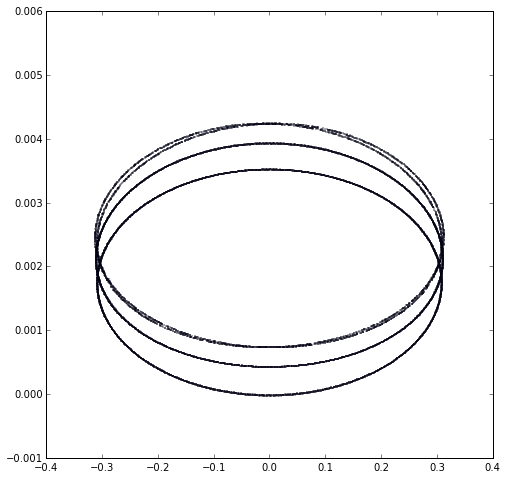

In [38]:
%matplotlib inline
pm_x = poincare_map[:,0]
pm_y = poincare_map[:,1]
if 0:
    pm_maskedx = np.ma.masked_where(pm_x>0., pm_x)
    pm_maskedy = np.ma.masked_where(pm_x>0., pm_y)
else:
    pm_maskedx = pm_x
    pm_maskedy = pm_y

    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter(pm_maskedx,pm_maskedy,marker=".",s=1.,alpha=.81)
print sim.t